In [1]:
import os

import numpy as np
import scipy
import scipy.ndimage
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

# For using Tensorboard inside a notebook
# %load_ext tensorboard

In [2]:
def load_tuning_result(results_path, method):
    results_df = pd.read_csv(results_path, sep='\t')

    remap_cols = {"config.lr": "lr", "config.gamma": "gamma"}
    results_df = results_df.rename(columns=remap_cols)
    results_df["method"] = method
    
    return results_df

    
def plot_mean_value(results_df, value_col="reward"):
    """Plot distribution of reward values"""
    plot_df = results_df.copy()
    plot_df["lr"] = plot_df["lr"].astype(str)
    lr_order = sorted(plot_df["lr"].unique(), key=lambda x: float(x))
    g = sns.stripplot(data=plot_df, x="lr", y=value_col, order=lr_order, hue="method")
    plt.legend(loc=(1.04, 0))
    
    
def plot_trials_successful(results_df, value_col="reward", min_value=200):
    """Set a success minimum, and plot what fraction of trials reach that threshold"""
    
    group_cols = ["lr", "method"]
    is_successful = lambda x: (x[[value_col]] >= min_value).mean()
    average_successful = results_df.groupby(group_cols).apply(is_successful)
    
    plot_df = average_successful.copy()
    plot_df = plot_df.reset_index()
    plot_df = plot_df.rename(columns={value_col: "fraction_successful"})
    plot_df["lr"] = plot_df["lr"].astype(str)
    
    g = sns.barplot(data=plot_df, x="lr", y="fraction_successful", hue="method")
    plt.legend(loc=(1.04, 0))

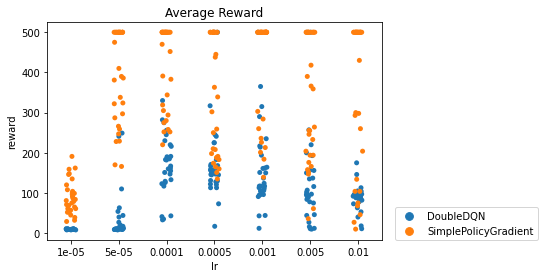

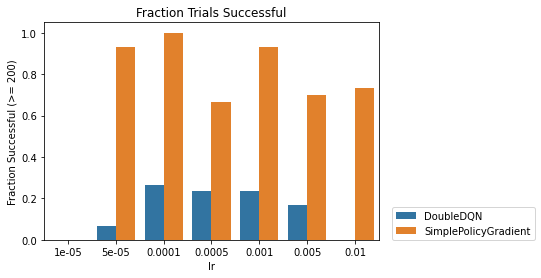

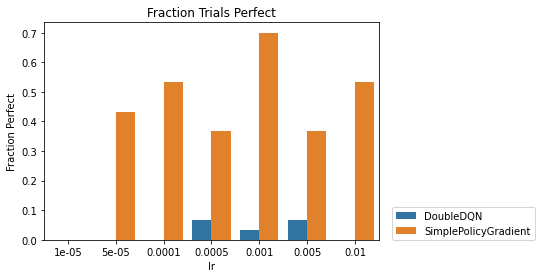

In [3]:
results_path = "DoubleDQN_CartPole-v1_lr_ep250_tuning_results.tsv"
results_df_DDQN = load_tuning_result(results_path, "DoubleDQN")

results_path = "SimplePolicyGradient_CartPole-v1_lr_tuning_results.tsv"
results_df_SPG = load_tuning_result(results_path, "SimplePolicyGradient")

results_df = pd.concat([results_df_DDQN, results_df_SPG])

plt.figure()
plot_mean_value(results_df)
_ = plt.title("Average Reward")

plt.figure()
plot_trials_successful(results_df, min_value=200)
_ = plt.title("Fraction Trials Successful")
_ = plt.ylabel("Fraction Successful (>= 200)")

plt.figure()
plot_trials_successful(results_df, min_value=500)
_ = plt.title("Fraction Trials Perfect")
_ = plt.ylabel("Fraction Perfect")

## Thoughts and Observations

1. Clearly, the SimplePolicyGradient method is way more successful. I used a fixed gamma of 0.99 for DQN based on earlier experiments just to get close to SPG, which implicitly uses a gamma of 1. 

2. For SPG, A learning rate of 1e-4 has the highest fraction successful, but 1e-3 has the most perfect trials. Also the average reward for 1e-4 is higher. And for some reason 5e-4 is worse than both. I may just be seeing variance over this range. Note that learning rate of 1e-4 is also the best for DoubleDQN. Unclear if these are actually comparable.


In [4]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

In [ ]:
dqn_path = "../logs/DoubleDQN/CartPole-v1"
dqn_info = parse_tensorboard(dqn_path, ['total_reward'])['total_reward']
dqn_info = dqn_info.sort_values("step")

spg_path = "../logs/SimplePolicyGradient/CartPole-v1"
spg_dict = parse_tensorboard(spg_path, ['total_reward', 'num_episodes'])

spg_info = spg_dict['total_reward'].rename(columns={'value': 'total_reward'})
spg_info['num_episodes'] = spg_dict['num_episodes']['value']
                                           
# display(spg_info)
spg_info['mean_reward'] = spg_info['total_reward'] / spg_info['num_episodes']
spg_info = spg_info.sort_values("step")

In [6]:
def uniform_filter_1d(yvals, window_width):
    _neighbors_window = np.ones(window_width, dtype=float) / window_width
    _filtered = scipy.ndimage.convolve1d(yvals, weights=_neighbors_window)
    return _filtered

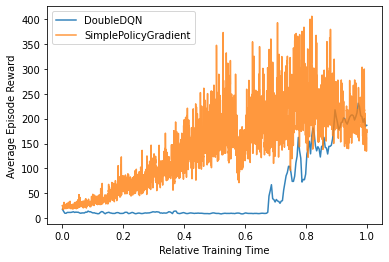

In [7]:
dqn_x = dqn_info['step'] / dqn_info['step'].max()
dqn_y = dqn_info['value'].values 
dqn_y = uniform_filter_1d(dqn_y, 3)

spg_x = spg_info['step'] / spg_info['step'].max()
spg_y = spg_info['mean_reward'].values
spg_y = uniform_filter_1d(spg_y, 3)


plt.figure()
_ = plt.plot(dqn_x, dqn_y, alpha=0.9, label='DoubleDQN')
_ = plt.plot(spg_x, spg_y, alpha=0.8, label="SimplePolicyGradient")
_ = plt.xlabel("Relative Training Time")
_ = plt.ylabel("Average Episode Reward")
_ = plt.legend(loc='upper left')

Note: I've tried training for 400 epochs and there seems to be an overtraining effect; performance peaks around 200-250 epochs. So here I'm showing 250 epochs.

Variance is much higher for SPG from run to run, but the long term trend is more stable. And there is continuous improvement from the very beginning.